In [1]:
# imports
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Loading dataset
path_df = r'C:\Users\91951\Downloads\dataset.csv'
df = pd.read_csv(path_df)

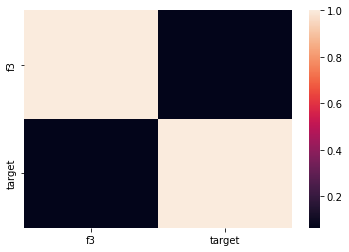

In [4]:
sns.heatmap(df.corr())
plt.show()

In [5]:
df.isna().sum()  # No empty cells

f1        0
f2        0
f3        0
f4        0
f5        0
f6        0
f7        0
target    0
dtype: int64

In [6]:
df.duplicated().sum()  # No duplicates

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


In [8]:
df.apply(lambda x: pd.to_numeric(x, errors='coerce')).isna().sum()  #we can drop Na values or just replace them with mean of the column data

f1        1
f2        1
f3        0
f4        1
f5        1
f6        1
f7        1
target    0
dtype: int64

In [9]:
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()  #3 rows dropped

from sklearn.preprocessing import MinMaxScaler  # useless

In [10]:
X = df.drop('target', axis=1).values
y = df.target
# print(X.dtypes)
# print(y.dtypes)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(type(X_train),type(X_test),type(y_train),type(y_test))

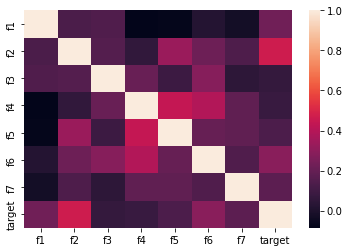

In [11]:
sns.heatmap(df.corr())
plt.show()

In [12]:
X_train

array([[ 0.94148548,  0.25092826, -0.05761952, ...,  0.38756454,
         0.8235221 , -0.10314457],
       [ 0.34669831,  1.15711521,  0.04529666, ..., -0.69463614,
        -0.27850747, -0.80181728],
       [-1.14026962,  0.5321587 , -3.55676965, ..., -0.69463614,
         0.54484796,  1.38454646],
       ...,
       [ 1.83366624, -0.62401086,  0.8686261 , ..., -0.69463614,
         1.72287957,  1.99588508],
       [-1.14026962,  0.62590217, -3.55676965, ..., -0.69463614,
         1.31753536, -0.80784032],
       [-1.14026962,  0.12593696,  1.38320701, ..., -0.69463614,
        -1.20319896, -0.63618367]])

# Base model

In [13]:
# function to calculate accuracy

def model_accuracy(y_true,y_pred):
    y_hat = y_pred.argmax(1,keepdim=True)
#     print("y_pred",y_pred)
    
    count = y_hat.eq(y_true.view_as(y_hat)).sum()
#     print("count",count)
    acc = count.float()/y_true.shape[0]
    return acc

In [14]:
import torch.nn as nn

class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ReLU()          # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.activation2(self.hidden_layer1(x))
        x = self.activation2(self.hidden_layer2(x))
        x = self.activation3(self.hidden_layer3(x))
        return x

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
train_acc_list = []                  ###########
test_acc_list = []            ###########

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_acc = 0          ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()
        
        #graph variables                               #########
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
        
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list.append(acc_var)
    test_acc_list.append(accuracy)

# Save the model weights
torch.save(model.state_dict(), 'sungjun_abhinav_assignment2_part1.h5')

Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 8
Training Accur

# Dropouts  // model_1


In [15]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.1)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ReLU()          # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_1 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
train_acc_list1 = []                  ###########
test_acc_list1 = []            ###########

for epoch in range(epochs):
    model_1.train()
    running_loss = 0.0
    epoch_acc = 0          ########## 
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
        
        
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_1.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_1(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total

    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list1.append(acc_var)
    test_acc_list1.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.5658
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7039
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6513
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 8
Training Accur

In [16]:
# Save the model weights
torch.save(model_1.state_dict(), r'sungjun_abhinav_assignment2_part2.h5')

# Dropouts // model_2

In [17]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ReLU()          # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_2 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
train_acc_list2 = []                  ###########
test_acc_list2 = []            ###########

for epoch in range(epochs):
    model_2.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_2.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_2(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list2.append(acc_var)
    test_acc_list2.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 8
Training Accur

In [18]:
# Save the model weights
torch.save(model_2.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Dropouts // model_3

In [19]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.1)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ReLU()          # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_3 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
train_acc_list3 = []                  ###########
test_acc_list3 = []            ###########

for epoch in range(epochs):
    model_3.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_3(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_3.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_3(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list3.append(acc_var)
    test_acc_list3.append(accuracy)




Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 8
Training Accur

In [20]:
# Save the model weights
torch.save(model_3.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Activation Function - LeakyRelu
# Model_4

In [21]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.LeakyReLU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.LeakyReLU()         # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_4 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
train_acc_list4 = []                  ###########
test_acc_list4 = []            ###########

for epoch in range(epochs):
    model_4.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_4(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_4.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_4(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list4.append(acc_var)
    test_acc_list4.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6579
**************************************************
Epoch : 8
Training Accur

In [22]:
# Save the model weights
torch.save(model_4.state_dict(), r'sungjun_abhinav_assignment2_part2.h5')

# Activation Function - Tanh
# Model_5

In [23]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.Tanh()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.Tanh()         # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_5 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_5.parameters(), lr=0.01)  
# optimizer = optim.Adam(params=model.parameters(),lr=0.03)     # setup 1 optimizer adam

# Train the model
epochs = 50
train_acc_list5 = []                  ###########
test_acc_list5 = []            ###########

for epoch in range(epochs):
    model_5.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_5(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on test data
    with torch.no_grad():
        model_5.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_5(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list5.append(acc_var)
    test_acc_list5.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.5592
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7632
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7566
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7632
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7566
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7434
**************************************************
Epoch : 8
Training Accur

In [24]:
# Save the model weights
torch.save(model_5.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Activation Function - ELU
# Model_6

In [25]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_6 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(model_6.parameters(), lr=0.01)  

# Train the model
epochs = 50
train_acc_list6 = []                  ###########
test_acc_list6 = []            ###########

for epoch in range(epochs):
    model_6.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_6(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_6.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_6(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list6.append(acc_var)
    test_acc_list6.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6447
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6645
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6645
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6645
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6711
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.6908
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7105
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7237
**************************************************
Epoch : 8
Training Accur

In [26]:
# Save the model weights
torch.save(model_6.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Optimizer Adams
# Model_7

In [27]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_7 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_7.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list7 = []                  ###########
test_acc_list7 = []            ###########
for epoch in range(epochs):
    model_7.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_7(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_7.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_7(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list7.append(acc_var)
    test_acc_list7.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7566
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7566
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7434
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7434
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7566
**************************************************
Epoch : 8
Training Accur

In [28]:
# Save the model weights
torch.save(model_7.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Optimizer - Adagrad
# Model_8

In [29]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_8 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(params=model_8.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list8 = []                  ###########
test_acc_list8 = []            ###########
for epoch in range(epochs):
    model_8.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_8(inputs)
        loss = criterion(outputs, labels)
        acc = model_accuracy(y_true=labels,y_pred=outputs) #####
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_8.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_8(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list8.append(acc_var)
    test_acc_list8.append(accuracy)



Epoch : 0
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7829
**************************************************
Epoch : 1
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7829
**************************************************
Epoch : 2
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7763
**************************************************
Epoch : 3
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7763
**************************************************
Epoch : 4
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 5
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 6
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7500
**************************************************
Epoch : 7
Training Accuracy : 0.6480263157894737
Test Accuracy: 0.7566
**************************************************
Epoch : 8
Training Accur

In [30]:
# Save the model weights
torch.save(model_8.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Optimizer - RMSPROP
# Model_9

In [31]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_9 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.RMSprop(params=model_9.parameters(),lr=0.1)

# Train the model
epochs = 50
train_acc_list9 = []                  ###########
test_acc_list9 = []            ###########

for epoch in range(epochs):
    model_9.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_9(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_9.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_9(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list9.append(acc_var)
    test_acc_list9.append(accuracy)



Epoch : 0
Training Accuracy : 0.71875
Test Accuracy: 0.4737
**************************************************
Epoch : 1
Training Accuracy : 0.71875
Test Accuracy: 0.6842
**************************************************
Epoch : 2
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
Epoch : 3
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
Epoch : 4
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
Epoch : 5
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
Epoch : 6
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
Epoch : 7
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
Epoch : 8
Training Accuracy : 0.71875
Test Accuracy: 0.6513
**************************************************
E

In [32]:
# Save the model weights
torch.save(model_9.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Initializer - Kaiming Initialization 
# Model_10

In [33]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.kaiming_normal_(self.input_layer.weight)
        nn.init.kaiming_normal_(self.hidden_layer1.weight)
        nn.init.kaiming_normal_(self.hidden_layer2.weight)
        nn.init.kaiming_normal_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_10 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_10.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list10 = []                  ###########
test_acc_list10 = []            ###########
for epoch in range(epochs):
    model_10.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_10(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_10.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_10(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list10.append(acc_var)
    test_acc_list10.append(accuracy)



Epoch : 0
Training Accuracy : 0.71875
Test Accuracy: 0.7368
**************************************************
Epoch : 1
Training Accuracy : 0.71875
Test Accuracy: 0.7500
**************************************************
Epoch : 2
Training Accuracy : 0.71875
Test Accuracy: 0.7500
**************************************************
Epoch : 3
Training Accuracy : 0.71875
Test Accuracy: 0.7566
**************************************************
Epoch : 4
Training Accuracy : 0.71875
Test Accuracy: 0.7434
**************************************************
Epoch : 5
Training Accuracy : 0.71875
Test Accuracy: 0.7368
**************************************************
Epoch : 6
Training Accuracy : 0.71875
Test Accuracy: 0.7500
**************************************************
Epoch : 7
Training Accuracy : 0.71875
Test Accuracy: 0.7303
**************************************************
Epoch : 8
Training Accuracy : 0.71875
Test Accuracy: 0.7566
**************************************************
E

In [34]:
# Save the model weights
torch.save(model_10.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Initializer - weights zeros
# Model_11

In [35]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.zeros_(self.input_layer.weight)
        nn.init.zeros_(self.hidden_layer1.weight)
        nn.init.zeros_(self.hidden_layer2.weight)
        nn.init.zeros_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_11 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_11.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list11 = []                  ###########
test_acc_list11 = []            ###########

for epoch in range(epochs):
    model_11.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_11(inputs)
        loss = criterion(outputs, labels)
        epoch_acc += acc.item()         #########
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_11.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_11(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list11.append(acc_var)
    test_acc_list11.append(accuracy)



Epoch : 0
Training Accuracy : 1.4375
Test Accuracy: 0.6579
**************************************************
Epoch : 1
Training Accuracy : 1.4375
Test Accuracy: 0.6579
**************************************************
Epoch : 2
Training Accuracy : 1.4375
Test Accuracy: 0.7105
**************************************************
Epoch : 3
Training Accuracy : 1.4375
Test Accuracy: 0.7500
**************************************************
Epoch : 4
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 5
Training Accuracy : 1.4375
Test Accuracy: 0.7697
**************************************************
Epoch : 6
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 7
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 8
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 9


In [36]:
# Save the model weights
torch.save(model_11.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Initializer - xavier
# Model_12

In [37]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_12 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_12.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list12 = []                  ###########
test_acc_list12 = []            ###########
for epoch in range(epochs):
    model_12.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_12(inputs)
        loss = criterion(outputs, labels)
        epoch_acc += acc.item()         #########
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_12.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_12(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list12.append(acc_var)
    test_acc_list12.append(accuracy)

Epoch : 0
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 1
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 2
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 3
Training Accuracy : 1.4375
Test Accuracy: 0.7500
**************************************************
Epoch : 4
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 5
Training Accuracy : 1.4375
Test Accuracy: 0.7500
**************************************************
Epoch : 6
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 7
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 8
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 9


In [38]:
# Save the model weights
torch.save(model_12.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Gradient clipping 
# Model_13

In [39]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_13 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_13.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list13 = []                  ###########
test_acc_list13 = []            ###########

for epoch in range(epochs):
    model_13.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_13(inputs)
        loss = criterion(outputs, labels)
        epoch_acc += acc.item()         #########
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping 
        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_13.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_13(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list13.append(acc_var)
    test_acc_list13.append(accuracy)

Epoch : 0
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 1
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 2
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 3
Training Accuracy : 1.4375
Test Accuracy: 0.7368
**************************************************
Epoch : 4
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 5
Training Accuracy : 1.4375
Test Accuracy: 0.7368
**************************************************
Epoch : 6
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 7
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 8
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 9


In [40]:
# Save the model weights
torch.save(model_13.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Batch Normalization 
# Model_14

In [41]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.batch1 = nn.BatchNorm1d(128)
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.batch2 = nn.BatchNorm1d(128)
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.batch3 = nn.BatchNorm1d(64)
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.batch1(x)
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.batch2(x)
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.batch3(x)
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_14 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_14.parameters(),lr=0.001)

# Train the model
epochs = 50
train_acc_list14 = []                  ###########
test_acc_list14 = []            ###########

for epoch in range(epochs):
    model_14.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_14(inputs)
        loss = criterion(outputs, labels)
        epoch_acc += acc.item()         #########
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping 

        optimizer.step()
        running_loss += loss.item()
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_14.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_14(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list14.append(acc_var)
    test_acc_list14.append(accuracy)

Epoch : 0
Training Accuracy : 1.4375
Test Accuracy: 0.7105
**************************************************
Epoch : 1
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 2
Training Accuracy : 1.4375
Test Accuracy: 0.7500
**************************************************
Epoch : 3
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 4
Training Accuracy : 1.4375
Test Accuracy: 0.7566
**************************************************
Epoch : 5
Training Accuracy : 1.4375
Test Accuracy: 0.7434
**************************************************
Epoch : 6
Training Accuracy : 1.4375
Test Accuracy: 0.7368
**************************************************
Epoch : 7
Training Accuracy : 1.4375
Test Accuracy: 0.7500
**************************************************
Epoch : 8
Training Accuracy : 1.4375
Test Accuracy: 0.7237
**************************************************
Epoch : 9


In [42]:
# Save the model weights
torch.save(model_14.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Learning rate scheduler
# Model_15

In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


# Define loss function and optimizer
# https://pytorch.org/docs/stable/nn.html#loss-functions
model_15 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model_15.parameters(),lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5) #scheduler call

# Train the model
epochs = 50
train_acc_list15 = []                  ###########
test_acc_list15 = []            ###########
for epoch in range(epochs):
    model_15.train()
    running_loss = 0.0
    epoch_acc = 0     ##########
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_15(inputs)
        loss = criterion(outputs, labels)
        epoch_acc += acc.item()         #########
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #gradient clipping 

        optimizer.step()
        running_loss += loss.item()
        scheduler.step(loss)
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
    # Print training loss at each epoch
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate the model on test data
    with torch.no_grad():
        model_15.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_15(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list15.append(acc_var)
    test_acc_list15.append(accuracy)

Epoch : 0
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 1
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 2
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 3
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 4
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 5
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 6
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 7
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 8
Training Accuracy : 1.4375
Test Accuracy: 0.7632
**************************************************
Epoch : 9


In [44]:
# Save the model weights
torch.save(model_15.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# cyclic Learning rate scheduler
# Model_16

In [45]:
from torch.optim.lr_scheduler import CyclicLR

class SimpleBinaryClassifier(nn.Module):
    def __init__(self):
        super(SimpleBinaryClassifier, self).__init__()
        self.dropouts = nn.Dropout(0.3)
        self.input_layer = nn.Linear(7, 128)   # input layer to hidden layer 1
        self.hidden_layer1 = nn.Linear(128, 128)  # hidden layer 1 to hidden layer 2
        self.hidden_layer2 = nn.Linear(128, 64)    # hidden layer 2 to hidden layer 3
        self.hidden_layer3 = nn.Linear(64,1) # hidden layer 2 to output layer
        self.activation1 = nn.ELU()          # activation function for hidden layers   (base setup)
        self.activation2 = nn.ELU()        # activation function for hidden layers
        self.activation3 = nn.Sigmoid()    # activation function for output layer   (base setup)
        # weights initiallization 
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        
    def forward(self, x):
        x = self.activation1(self.input_layer(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer1(x))
        x = self.dropouts(x)
        x = self.activation2(self.hidden_layer2(x))
        x = self.dropouts(x)
        x = self.activation3(self.hidden_layer3(x))
        return x

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values.reshape(-1, 1)).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # batch size tune
test_loader = DataLoader(test_dataset, batch_size=32)


model_16 = SimpleBinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.SGD(params=model_16.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, mode='triangular')

# Train the model
epochs = 50
train_acc_list16 = []                  ###########
test_acc_list16 = []            ###########

for epoch in range(epochs):
    model_16.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_16(inputs)
        loss = criterion(outputs, labels)
        epoch_acc += acc.item()         #########
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        scheduler.step(loss)
        epoch_acc += acc.item()         #########
        
        #graph variables                               
        loss_var = running_loss/len(train_loader)
        acc_var = epoch_acc/len(train_loader)
    
  

    # Evaluate the model on test data
    with torch.no_grad():
        model_16.eval()
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model_16(inputs)
            predicted_labels = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
        accuracy = correct / total
    
    print(f"Epoch : {epoch}")       ##########
    print(f"Training Accuracy : {acc_var}")
    print(f'Test Accuracy: {accuracy:.4f}')
    print("*"*50)
    train_acc_list15.append(acc_var)
    test_acc_list15.append(accuracy)

D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch : 0
Training Accuracy : 2.875
Test Accuracy: 0.7171
**************************************************
Epoch : 1
Training Accuracy : 4.3125
Test Accuracy: 0.7697
**************************************************
Epoch : 2
Training Accuracy : 5.75
Test Accuracy: 0.7763
**************************************************
Epoch : 3
Training Accuracy : 7.1875
Test Accuracy: 0.7895
**************************************************
Epoch : 4
Training Accuracy : 8.625
Test Accuracy: 0.7632
**************************************************
Epoch : 5
Training Accuracy : 10.0625
Test Accuracy: 0.7632
**************************************************
Epoch : 6
Training Accuracy : 11.5
Test Accuracy: 0.7632
**************************************************
Epoch : 7
Training Accuracy : 12.9375
Test Accuracy: 0.7632
**************************************************
Epoch : 8
Training Accuracy : 14.375
Test Accuracy: 0.7500
**************************************************
Epoch : 9
Trai

In [46]:
# Save the model weights
torch.save(model_16.state_dict(), r'sungjun_abhinav_assignment2_part1.h5')

# Graph

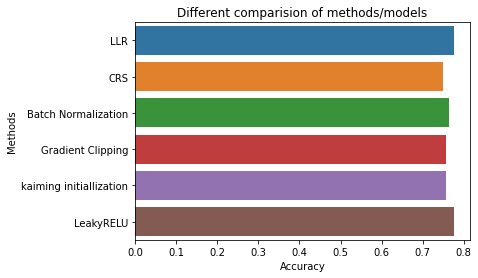

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_list = [0.7763,0.75,0.7632,0.7566,0.7566,0.7763]
names_list = ["LLR","CRS","Batch Normalization","Gradient Clipping","kaiming initiallization","LeakyRELU"]

sns.barplot(y=names_list,x=acc_list)
sns.color_palette("pastel")
plt.xlabel("Accuracy")
plt.ylabel("Methods")
plt.title("Different comparision of methods/models")
plt.show()

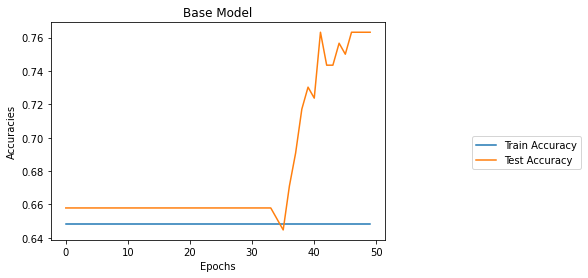

In [57]:
plt.plot(list(range(50)),train_acc_list,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list,label = "Test Accuracy")
plt.title("Base Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

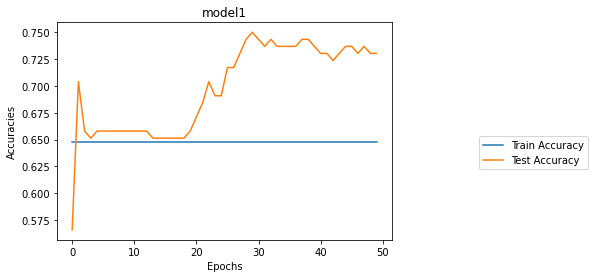

In [58]:
plt.plot(list(range(50)),train_acc_list1,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list1,label = "Test Accuracy")
plt.title("model1")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

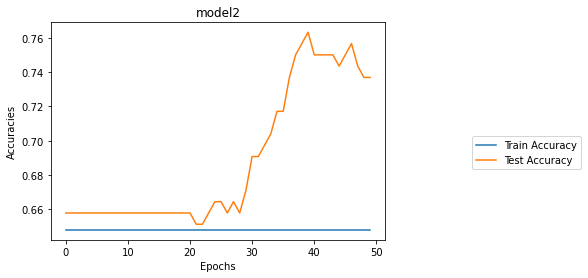

In [59]:
plt.plot(list(range(50)),train_acc_list2,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list2,label = "Test Accuracy")
plt.title("model2")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

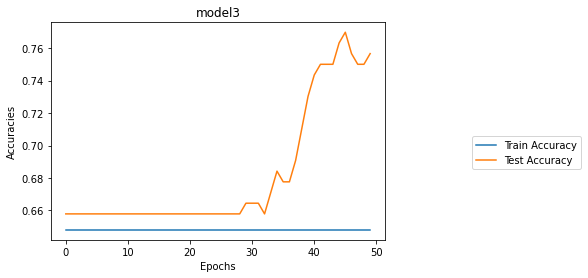

In [60]:
plt.plot(list(range(50)),train_acc_list3,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list3,label = "Test Accuracy")
plt.title("model3")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

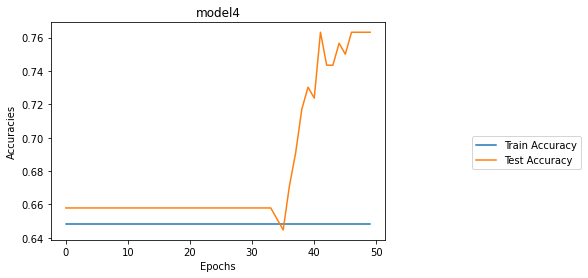

In [61]:
plt.plot(list(range(50)),train_acc_list4,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list,label = "Test Accuracy")
plt.title("model4")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

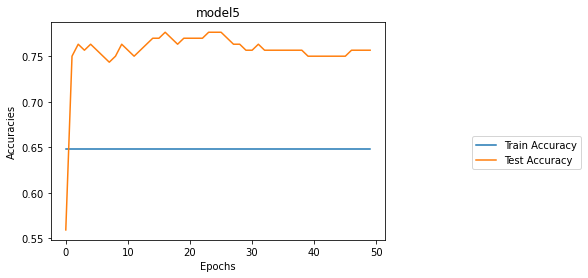

In [62]:
plt.plot(list(range(50)),train_acc_list5,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list5,label = "Test Accuracy")
plt.title("model5")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

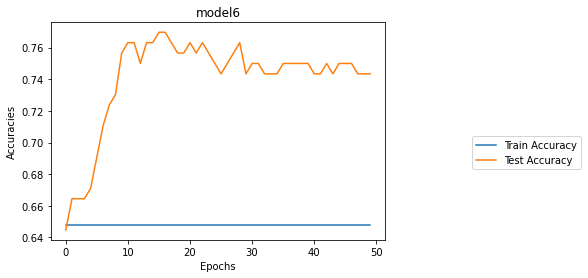

In [63]:
plt.plot(list(range(50)),train_acc_list6,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list6,label = "Test Accuracy")
plt.title("model6")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

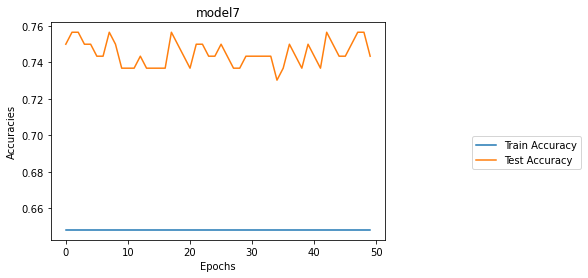

In [64]:
plt.plot(list(range(50)),train_acc_list7,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list7,label = "Test Accuracy")
plt.title("model7")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

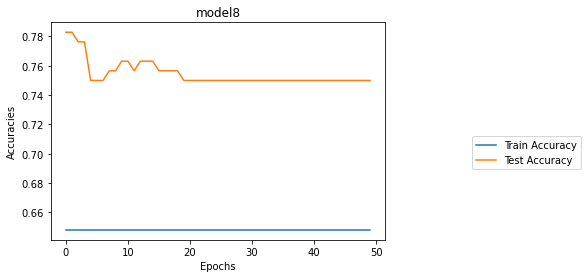

In [65]:
plt.plot(list(range(50)),train_acc_list8,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list8,label = "Test Accuracy")
plt.title("model8")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

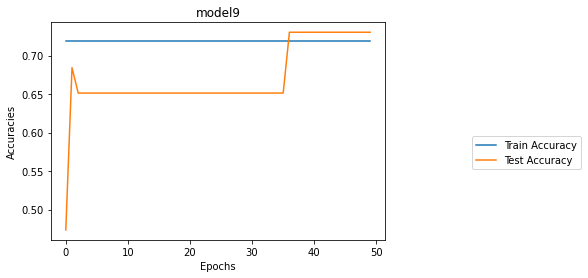

In [66]:
plt.plot(list(range(50)),train_acc_list9,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list9,label = "Test Accuracy")
plt.title("model9")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

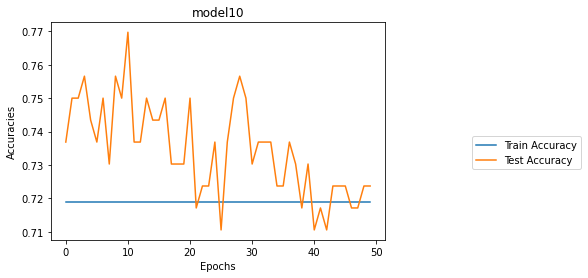

In [67]:
plt.plot(list(range(50)),train_acc_list10,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list10,label = "Test Accuracy")
plt.title("model10")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

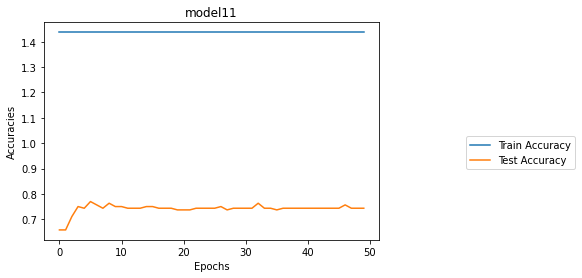

In [68]:
plt.plot(list(range(50)),train_acc_list11,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list11,label = "Test Accuracy")
plt.title("model11")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

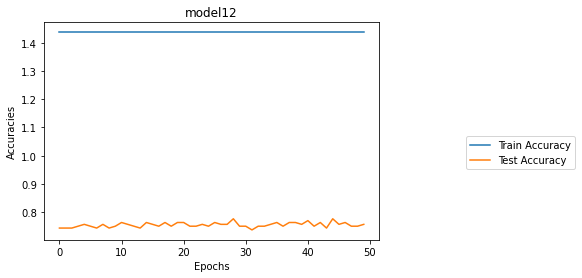

In [69]:
plt.plot(list(range(50)),train_acc_list12,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list12,label = "Test Accuracy")
plt.title("model12")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

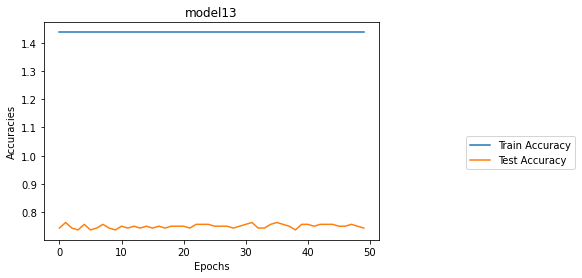

In [70]:
plt.plot(list(range(50)),train_acc_list13,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list13,label = "Test Accuracy")
plt.title("model13")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

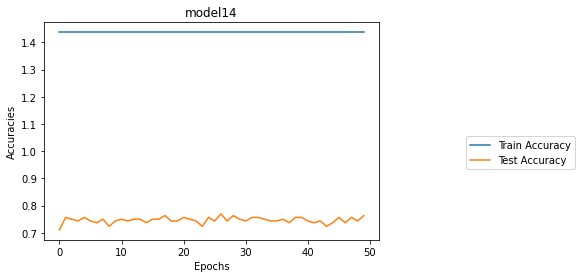

In [71]:
plt.plot(list(range(50)),train_acc_list14,label="Train Accuracy")
plt.plot(list(range(50)),test_acc_list14,label = "Test Accuracy")
plt.title("model14")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()